In [1]:
import pandas as pd
import numpy as np
import re
from geopy.distance import geodesic
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor
import shap

In [2]:
df = pd.read_csv('realty_data.csv')

Видим, что у распределения целевой переменной тяжелый хвост справа, посмотрим на распределение логарифма переменной.

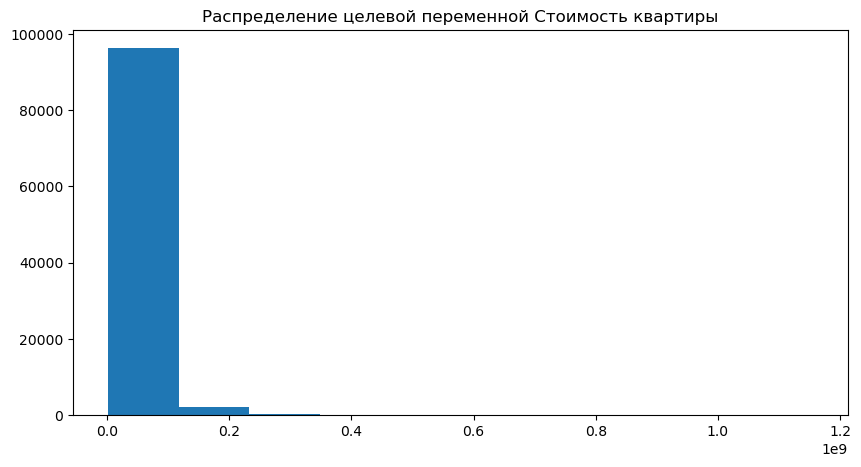

In [3]:
plt.figure(figsize=(10,5))
plt.title('Распределение целевой переменной Стоимость квартиры')
plt.hist(df['price'], bins=10)
plt.show()

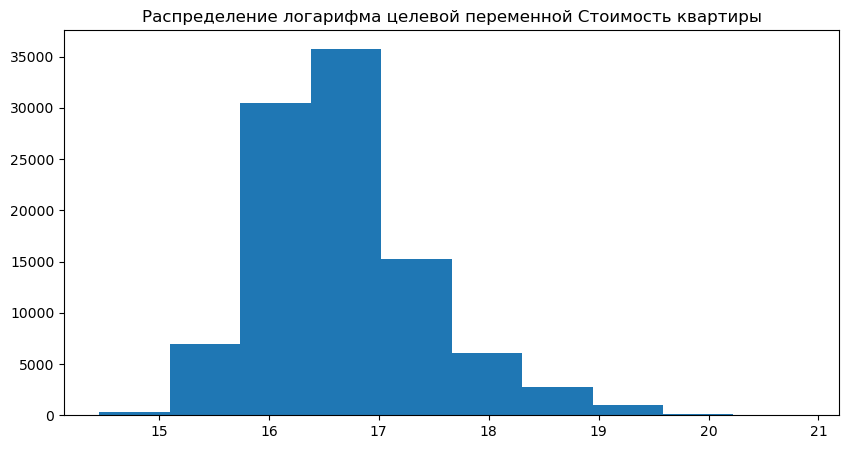

In [4]:
plt.figure(figsize=(10,5))
plt.title('Распределение логарифма целевой переменной Стоимость квартиры')
plt.hist(np.log(df['price']), bins=10)
plt.show()

In [5]:
df.head()

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
0,"3-комнатная, 137 м²",NaN,63000000,127473.0,"2-й Щемиловский переулок, 5а",55.778894,37.608844,Квартира,137.0,3.0,6.0,Москва,NaN,Тверской район,NaN,Просторная квартира свободной планировки с пан...,ЦИАН
1,"Студия, 16,7 м²",NaN,3250000,108815.0,"Харлампиева, 46",55.551025,37.313054,Квартира,16.7,NaN,1.0,Москва,NaN,Филимонковское поселение,NaN,ВНИМАНИЕ! ОЧЕНЬ ПРИВЛЕКАТЕЛЬНОЕ ПРЕ...,Домклик
2,"3-комнатная, 76 м²",NaN,16004680,NaN,"ЖК Прокшино, 8 к4",55.594802,37.431264,Квартира,76.0,3.0,6.0,Москва,NaN,Сосенское поселение,NaN,"Apт.1684018. 0,01% - гибкая ипотека! Воспользу...",Яндекс.Недвижимость
3,"1-комнатная, 24 м²",NaN,7841776,NaN,"ЖК Прокшино, 6 к2",55.594332,37.428099,Квартира,24.0,1.0,10.0,Москва,NaN,Сосенское поселение,NaN,Продается однокомнатная квартира № 381 в новос...,Новострой-М
4,"3-комнатная, 126 м²",NaN,120000000,121352.0,"Давыдковская, 18",55.721097,37.464342,Квартира,126.0,3.0,16.0,Москва,NaN,Фили-Давыдково район,NaN,Шикарное предложение!\nПродаётся трёхкомнатная...,Домклик


In [6]:
df.shape

(98822, 17)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98822 entries, 0 to 98821
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   product_name  98822 non-null  object 
 1   period        0 non-null      float64
 2   price         98822 non-null  int64  
 3   postcode      93675 non-null  float64
 4   address_name  98821 non-null  object 
 5   lat           98822 non-null  float64
 6   lon           98822 non-null  float64
 7   object_type   98822 non-null  object 
 8   total_square  98822 non-null  float64
 9   rooms         94840 non-null  float64
 10  floor         98822 non-null  float64
 11  city          91928 non-null  object 
 12  settlement    6894 non-null   object 
 13  district      75111 non-null  object 
 14  area          19498 non-null  object 
 15  description   98573 non-null  object 
 16  source        98822 non-null  object 
dtypes: float64(7), int64(1), object(9)
memory usage: 12.8+ MB


In [8]:
df.describe(include='all')

,product_name,period,price,postcode,address_name,lat,lon,object_type,total_square,rooms,floor,city,settlement,district,area,description,source
count,98822,0.0,9.882200e+04,93675.000000,98821,98822.000000,98822.000000,98822,98822.000000,94840.000000,98822.000000,91928,6894,75111,19498,98573,98822
unique,5827,NaN,NaN,NaN,22083,NaN,NaN,1,NaN,NaN,NaN,21,46,130,269,94910,4
top,"1-комнатная, 38 м²",NaN,NaN,NaN,"улица Академика Королёва, 21",NaN,NaN,Квартира,NaN,NaN,NaN,Москва,пос. Коммунарка,Сосенское поселение,Самолёт м-н,Дом «Достижение» располагается в Москве в окру...,ЦИАН
freq,954,NaN,NaN,NaN,1203,NaN,NaN,98822,NaN,NaN,NaN,73180,627,4780,649,408,42171
mean,NaN,NaN,2.512122e+07,124503.585119,NaN,55.742691,37.586404,NaN,66.092176,2.197427,9.905274,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,3.607234e+07,11956.742109,NaN,0.107044,0.169843,NaN,48.816204,1.038628,8.219180,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,NaN,1.900000e+06,101000.000000,NaN,55.468426,37.136489,NaN,8.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,NaN,1.050000e+07,115516.000000,NaN,55.673101,37.471611,NaN,40.100000,1.000000,4.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,NaN,1.516713e+07,123154.000000,NaN,55.745474,37.569365,NaN,56.400000,2.000000,8.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,NaN,2.500000e+07,140003.000000,NaN,55.817697,37.689568,NaN,75.700000,3.000000,14.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [9]:
df.settlement.value_counts()

settlement
пос. Коммунарка                              627
д. Путилково                                 499
пос. Развилка                                364
рп. Дрожжино                                 337
рп. Новоивановское                           281
рп. Нахабино                                 260
рп. Лопатино                                 259
пос. Нагорное                                227
рп. Боброво                                  220
д. Мисайлово                                 201
д. Сапроново                                 199
д. Сабурово                                  198
рп. Заречье                                  188
пос. Марьино                                 173
рп. Октябрьский                              164
д. Глухово                                   152
д. Островцы                                  150
д. Сосенки                                   145
дп. Красково                                 139
с. Николо-Урюпино                            119
пос. Битц

Описание столбцов:

product_name - наименование объекта недвижимости-\
period - дата\\
postcode - почтовый индекс\
address_name - адрес объекта\
lat - координаты (широта)\
lon - координаты (долгота)\
object_type - тип объекта\
total_square - общая площадь\
rooms - количество комнат\
floor - этаж\
city - город\
settlement - населенный пункт\
district - район\
area - микрорайон\
description - текст объявления\
source - источник

Видим, что период всегда NaN - можем убрать этот столбец.\
Среди object_type встречаются только 'Квартира' - можем убрать этот столбец.\
Проверим, что кол-во комнат и метров совпадают с указанными из наименования объекта недвижимости.

In [10]:
df[(df['lat'] >= -90) & (df['lat'] <= 90) & (df['lon'] >= -180) & (df['lon'] <= 180)].shape

(98822, 17)

In [11]:
def parse_product_name(product_name):
    match = re.match(r'(Студия|Квартира|(\d+)-комнатная),\s*([\d,]+)\s*м²', product_name)
    if match:
        rooms_str, rooms_number, square_str = match.groups()
        if rooms_str == 'Студия':
            rooms = 1
        elif rooms_str != 'Квартира':
            rooms = int(rooms_number)
        else:
            rooms = np.nan
        total_square = float(square_str.replace(',', '.'))
        return rooms, total_square
    else:
        return None, None

df['product_name'] = df['product_name'].astype(str)
df['parsed_rooms'], df['parsed_total_square'] = zip(*df['product_name'].map(parse_product_name))

In [12]:
df['rooms_match'] = df['rooms'] == df['parsed_rooms']
df['square_match'] = df['total_square'] == df['parsed_total_square']

In [13]:
df[df['rooms_match'] == False][['product_name', 'parsed_rooms', 'rooms']]

,product_name,parsed_rooms,rooms
1,"Студия, 16,7 м²",1.0,NaN
52,"Квартира, 40,5 м²",NaN,NaN
101,"Студия, 39,8 м²",1.0,NaN
106,"Студия, 19,9 м²",1.0,NaN
128,"Студия, 19,8 м²",1.0,NaN
...,...,...,...
98707,"Студия, 28,4 м²",1.0,NaN
98716,"Квартира, 78,2 м²",NaN,NaN
98762,"Студия, 100,1 м²",1.0,NaN
98791,"Студия, 170 м²",1.0,NaN


Заполним пропущенные значения кол-ва комнат:\
Для студий присвоим 1, остальным присвоим медиану.

In [14]:
df.loc[
    (df['rooms'] != df['parsed_rooms']) & (df['product_name'].str.contains('Студия')),
    'rooms'
] = 1

In [15]:
df.loc[
    (df['rooms'].isna()) & (df['description'].str.contains('студия')),
    'rooms'
] = 1

In [16]:
df.loc[df['rooms'].isna(), 'rooms'] = df['rooms'].median()

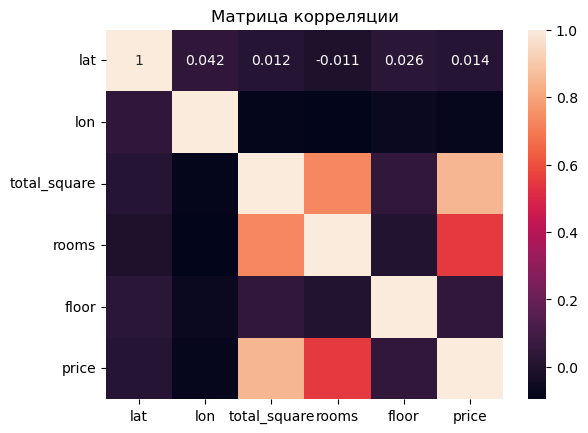

In [17]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor']
target_name = 'price'
correlation_matrix = df[num_features + [target_name]].corr()

sns.heatmap(correlation_matrix, annot=True)

plt.title("Матрица корреляции")
plt.show()

In [18]:
correlation_matrix

,lat,lon,total_square,rooms,floor,price
lat,1.000000,0.041690,0.011844,-0.011208,0.026498,0.013819
lon,0.041690,1.000000,-0.085288,-0.095377,-0.068114,-0.079017
total_square,0.011844,-0.085288,1.000000,0.728611,0.046666,0.849175
rooms,-0.011208,-0.095377,0.728611,1.000000,0.007215,0.548963
floor,0.026498,-0.068114,0.046666,0.007215,1.000000,0.046228
price,0.013819,-0.079017,0.849175,0.548963,0.046228,1.000000


Видим высокую корреляцию целевой переменной и кол-ва комнат, кол-ва метров.\
Помимо этого, видим корреляцию между кол-вом комнат и метров.

Обучим линейную регрессию.

In [35]:
def prepare_data_for_linreg(data, num_features, cat_features, target_name, log_target=False):
    X = data[num_features + cat_features]
    if log_target:
        y = np.log(data[target_name])
    else:
        y = data[target_name]

    num_transformer = StandardScaler()
    cat_transformer = OneHotEncoder(handle_unknown='ignore')
    
    preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_features),
        ('cat', cat_transformer, cat_features)
    ]
    )

    pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
    ])

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")

In [20]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor']
cat_features = ['city', 'source']
target_name = 'price'
prepare_data_for_linreg(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=False)

Mean Squared Error: 318385889525860.44
R^2 Score: 0.7622891343056204


In [36]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor']
cat_features = ['city', 'source']
target_name = 'price'
prepare_data_for_linreg(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=True)

Mean Squared Error: 0.15613152608474948
R^2 Score: 0.7298559509229172


Добавим признак расстояния от центра Москвы.

In [22]:
moscow_center = (55.7558, 37.6173)
df['distance_to_center'] = df.apply(
    lambda row: geodesic((row['lat'], row['lon']), moscow_center).kilometers if not pd.isnull(row['lat']) else None,
    axis=1
)

In [23]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor', 'distance_to_center']
cat_features = ['city', 'source']
target_name = 'price'
prepare_data_for_linreg(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=False)

Mean Squared Error: 285392548737630.6
R^2 Score: 0.7869223729601329


In [24]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor', 'distance_to_center']
cat_features = ['city', 'source']
target_name = 'price'
prepare_data_for_linreg(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=True)

Mean Squared Error: 0.09977349653572731
R^2 Score: 0.8273685204991257


In [25]:
def prepare_data_for_gradboost(data, num_features, cat_features, target_name, log_target=False):
    X = data[num_features + cat_features]
    if log_target:
        y = np.log(data[target_name])
    else:
        y = data[target_name]

    X[cat_features] = X[cat_features].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model = CatBoostRegressor(verbose=False)
    model.fit(X_train, y_train, cat_features)
    y_pred = model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse}")
    print(f"R^2 Score: {r2}")
    return X_train, X_test, model

In [26]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor', 'distance_to_center']
cat_features = ['city', 'source']
target_name = 'price'
X_train, X_test, model_cb_1 = prepare_data_for_gradboost(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=False)

/var/folders/p9/vnnlv1s11ljbxq3k32k1tfkm0000gn/T/ipykernel_49495/3699202529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_features] = X[cat_features].astype(str)


Mean Squared Error: 150280492815671.03
R^2 Score: 0.8877987146434466


In [27]:
num_features = ['lat', 'lon', 'total_square', 'rooms', 'floor', 'distance_to_center']
cat_features = ['city', 'source']
target_name = 'price'
X_train, X_test, model_cb_2 = prepare_data_for_gradboost(df, num_features=num_features, cat_features=cat_features, target_name=target_name, log_target=True)

/var/folders/p9/vnnlv1s11ljbxq3k32k1tfkm0000gn/T/ipykernel_49495/3699202529.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[cat_features] = X[cat_features].astype(str)


Mean Squared Error: 0.022187988830678487
R^2 Score: 0.9616095910037861


Получили высокую точность предсказания для CatBoost для логарифма целевой переменной.\
Посмотрим с помощью SHAP, какое влияние оказали признаки на предсказание.

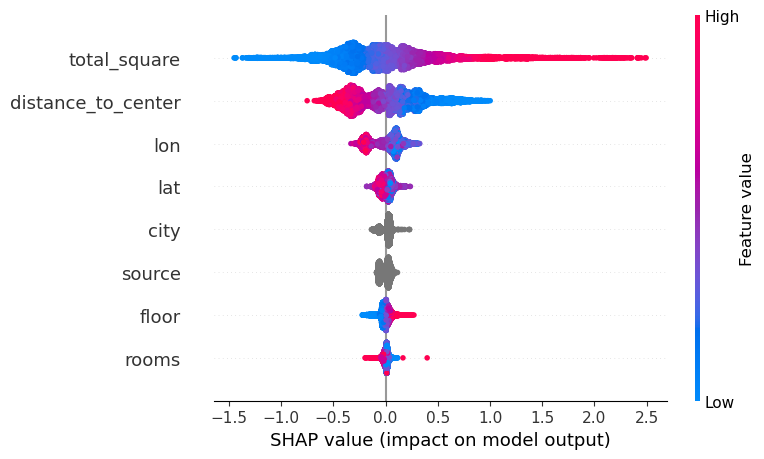

In [28]:
explainer = shap.TreeExplainer(model_cb_2, feature_perturbation="tree_path_dependent")
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)

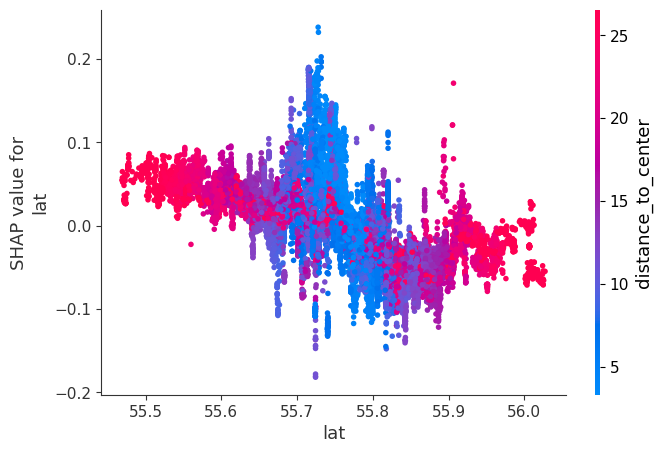

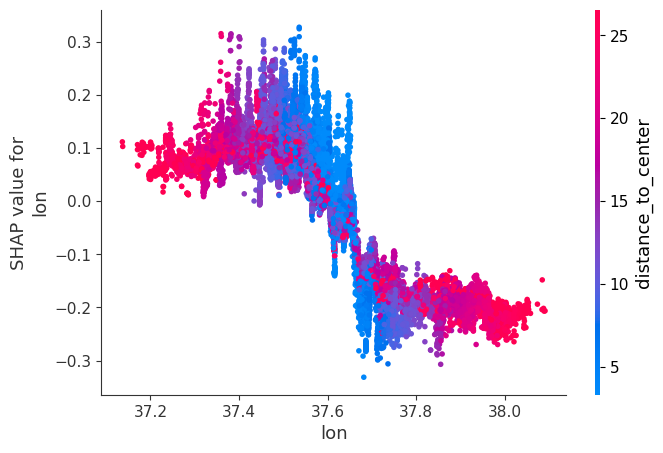

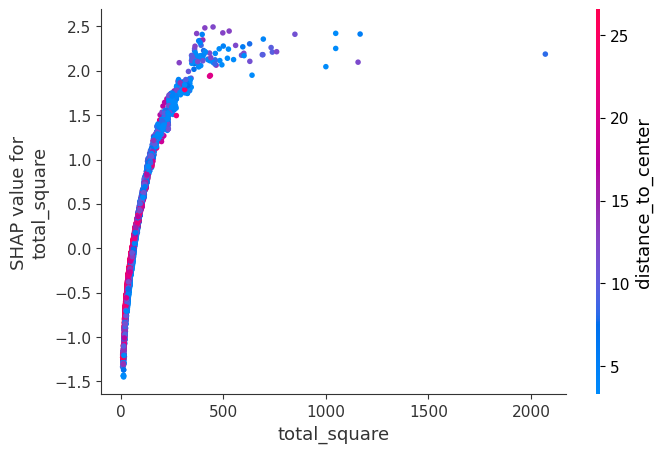

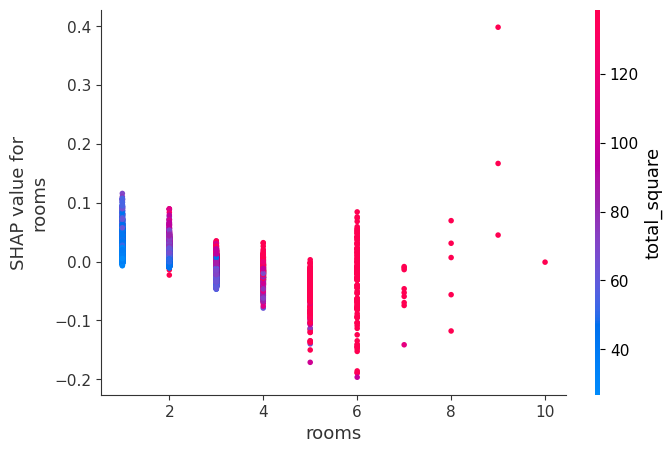

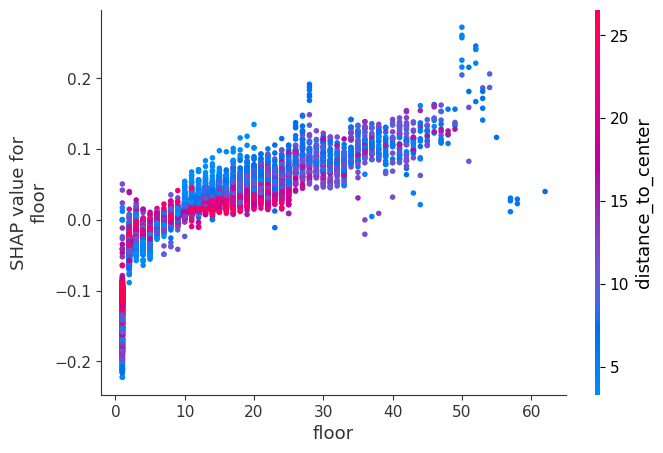

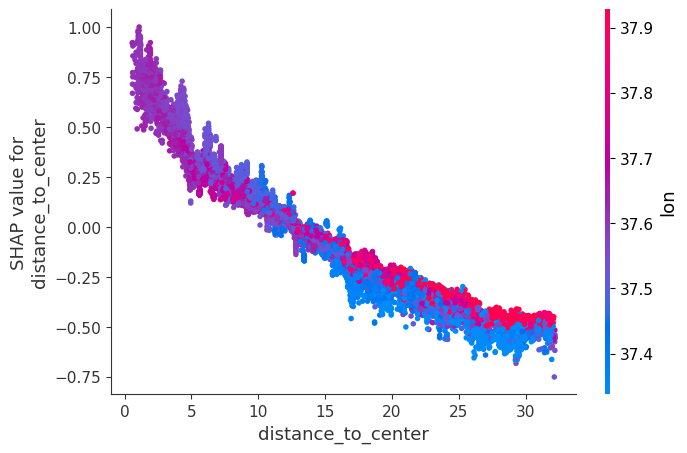

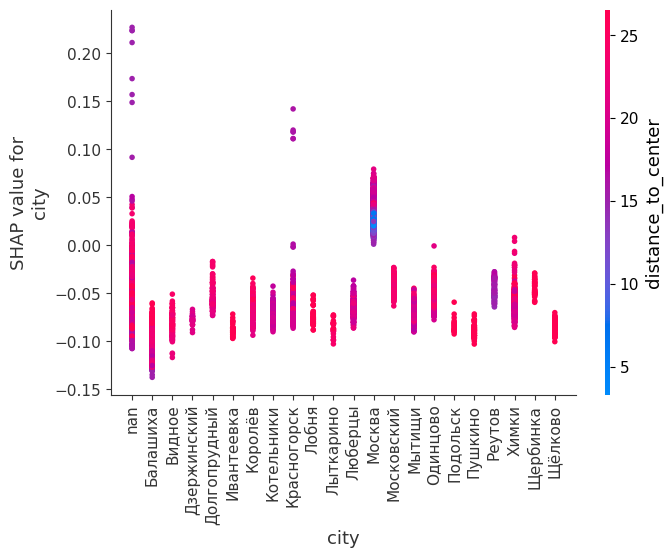

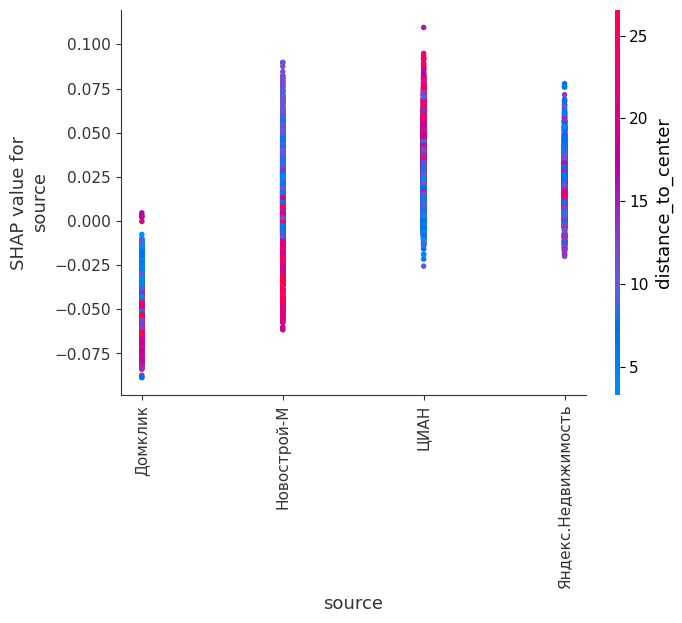

In [29]:
for feature in num_features + cat_features:
    shap.dependence_plot(feature, shap_values, X_test)

Видим, что высокое кол-во квадратов и комнат приводят к высокой цене.\
Помимо этого, близость к центру тоже приводит к высокой цене.


Для улучшения модели необходимо на кросс-валидации подобрать параметры модели.\
Помимо этого, можно попробовать добавить еще признаков на базе гео-данных - кластеризовать районы, например.